Run all the Cells from starting to end. Don't Skip any cells in between. The program is desinged in a way it has to be executed from the First cell.

Here we are Initialing the global random state to ensure reproducibility across Python, NumPy,
and PyTorch, and automatically configures the compute device to use a GPU (CUDA)
if available, falling back to CPU otherwise.


In [1]:
import random, numpy as np, torch

SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
if torch.cuda.is_available(): torch.cuda.manual_seed_all(SEED)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", DEVICE)


Device: cuda


In [2]:
# Install libraries (pinned)
!pip -q uninstall -y numpy opencv-python opencv-python-headless umap-learn || true
!pip -q install datasets==3.0.1 transformers==4.44.2 scikit-learn==1.5.2 \
                shap==0.46.0 captum==0.7.0 nltk==3.9.1 tqdm==4.66.5 \
                matplotlib==3.9.2 evaluate==0.4.3 pandas==2.2.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.9/60.9 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 22.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 69.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 94.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 543.9/543.9 kB 22.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 59.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.4/78.4 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 90.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.6/177.6 kB 17.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6

In [3]:

import sys, importlib, types

def _printfmt(name, ver):
    print(f"v {name:<13} {ver}")

print("=== STEP 0C — Verify imports & versions (resilient) ===")
try:
    import numpy as _np;     _printfmt("numpy", _np.__version__)
except Exception as e:
    _printfmt("numpy", f"unavailable ({e})")

for _pkg in ("transformers","datasets","evaluate","matplotlib","pandas","shap","captum"):
    try:
        m = importlib.import_module(_pkg)
        _printfmt(_pkg, getattr(m,"__version__", "n/a"))
    except Exception as e:
        _printfmt(_pkg, f"unavailable ({e})")

_need_patch = True
try:
    import sklearn  # try as-is first
    _printfmt("scikit-learn", sklearn.__version__)
    _need_patch = False
except Exception as e_first:
    msg = str(e_first)
    print(f"[env] sklearn import failed: {msg}")
    if "_add_to_diagonal" in msg:
        print("[env] Applying in-memory shim for sklearn.utils._array_api._add_to_diagonal …")
        import numpy as np
        modname = "sklearn.utils._array_api"
        api = sys.modules.get(modname)
        if api is None:
            api = types.ModuleType(modname)
            sys.modules[modname] = api
        if not hasattr(api, "_add_to_diagonal"):
            def _add_to_diagonal(X, value):
                # Works for (..., n, n) arrays: add 'value' to the diagonal in-place
                i = np.arange(min(X.shape[-2], X.shape[-1]))
                X[..., i, i] += value
                return X
            api._add_to_diagonal = _add_to_diagonal
        try:
            import sklearn  # retry
            _printfmt("scikit-learn", sklearn.__version__)
            _need_patch = False
            print("[env] sklearn import OK after shim.")
        except Exception as e_second:
            print(f"[env] Shim attempt failed: {e_second}")

if _need_patch:
    import subprocess
    def _pip(*args):
        print(">> pip", *args)
        subprocess.check_call([sys.executable, "-m", "pip", *args])

    TARGET_SKLEARN = "1.4.2"
    TARGET_NUMPY   = "1.26.4"
    TARGET_SCIPY   = "<1.14"

    print("\n[env] Installing a known-good set (this runs once):")
    _pip("uninstall", "-y", "scikit-learn")
    _pip("install", "--no-cache-dir",
         f"numpy=={TARGET_NUMPY}",
         f"scipy{TARGET_SCIPY}",
         f"scikit-learn=={TARGET_SKLEARN}",
    )
    print("\n[env] Please now do:  Runtime ▸ Restart runtime")
    print("[env] After restart, run all from the top; this cell will detect the fixed state.")
    raise SystemExit(0)
else:
    print("[env] All good — continuing.")


=== STEP 0C — Verify imports & versions (resilient) ===
v numpy         2.0.2
v transformers  4.44.2
v datasets      3.0.1
v evaluate      0.4.3
v matplotlib    3.10.0
v pandas        2.2.2
v shap          0.46.0
v captum        0.7.0
v scikit-learn  1.5.2
[env] All good — continuing.


Purpose: load dataset, make a reproducible stratified split, and visualize review lengths.

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

plain_text/train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

plain_text/test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

plain_text/unsupervised-00000-of-00001.p(…):   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Sizes → train: 22500 val: 2500 test: 25000
Train balance → pos: 11250 neg: 11250
Sample review: "Algie, the Miner" is one bad and unfunny silent comedy. The timing of the slapstick is completely off. This is the kind of humor with certain sequences that make you wonder if they're supposed to be  ...


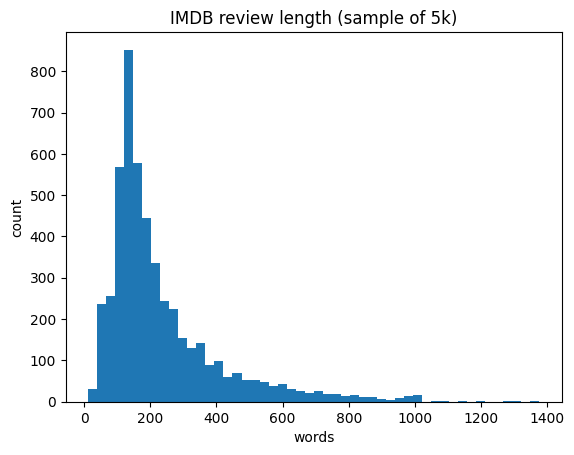

In [4]:

# This fetches the public 'imdb' dataset from Hugging Face.
from datasets import load_dataset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# 1) Load IMDB (train/test)
ds = load_dataset("imdb")                     # data is split into -> ds["train"], ds["test"]

train_texts, train_labels = ds["train"]["text"], ds["train"]["label"]
test_texts,  test_labels  = ds["test"]["text"],  ds["test"]["label"]

# 2) Stratified train/validation split (10% of train for validation)
X_tr, X_val, y_tr, y_val = train_test_split(
    train_texts,
    train_labels,
    test_size=0.10,
    stratify=train_labels,
    random_state=42
)

print("Sizes → train:", len(X_tr), "val:", len(X_val), "test:", len(test_texts))
print("Train balance → pos:", sum(y_tr), "neg:", len(y_tr) - sum(y_tr))
print("Sample review:", X_tr[0][:200].replace("\n", " "), "...")

# 3) Quick EDA: histogram of review word counts
lengths = [len(t.split()) for t in X_tr[:5000]]
plt.figure()
plt.hist(lengths, bins=50)
plt.title("IMDB review length (sample of 5k)")
plt.xlabel("words"); plt.ylabel("count")
plt.show()


Extra EDA (class balance & length by class)

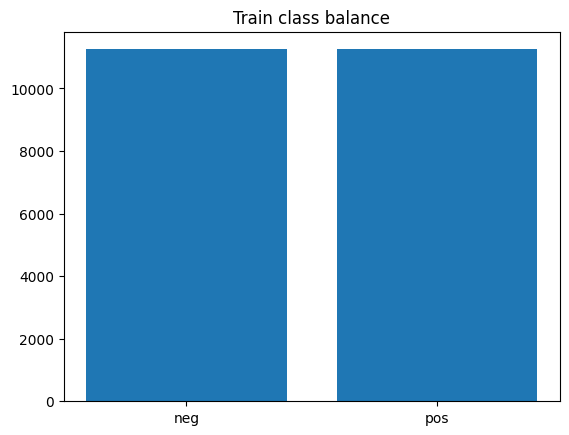

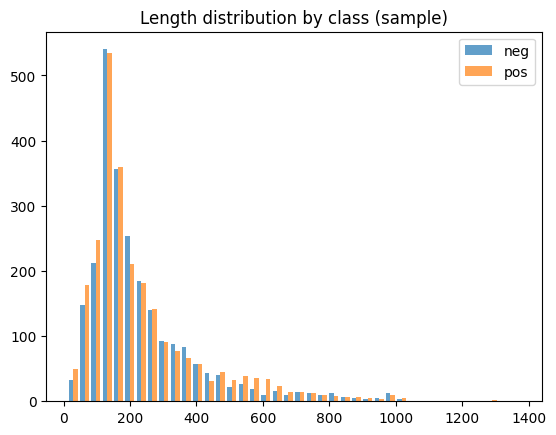

In [5]:
# Class balance (train)
import matplotlib.pyplot as plt, numpy as np, collections
cb = collections.Counter(y_tr)
plt.bar(["neg","pos"], [cb[0], cb[1]]); plt.title("Train class balance"); plt.show()

# Review length by class (small sample)
neg_len = [len(t.split()) for t,l in zip(X_tr[:5000], y_tr[:5000]) if l==0]
pos_len = [len(t.split()) for t,l in zip(X_tr[:5000], y_tr[:5000]) if l==1]
plt.hist([neg_len, pos_len], bins=40, label=["neg","pos"], alpha=0.7)
plt.title("Length distribution by class (sample)"); plt.legend(); plt.show()


Removes HTML tags like <br /> and collapses extra spaces so tokens such as br don’t appear in SHAP/TF-IDF feature

In [6]:
import re, html

# remove <br>, <br/>, <br /> in any case, any other tags, and orphan "br" tokens
BR_TAG    = re.compile(r'(<\s*br\s*/?\s*>)+', flags=re.I)
TAG_RE    = re.compile(r'<[^>]+>')
ORPHAN_BR = re.compile(r'\bbr\b', flags=re.I)

def clean_text(s: str) -> str:
    s = html.unescape(s)
    s = BR_TAG.sub(' ', s)            # drop explicit <br> tags
    s = TAG_RE.sub(' ', s)            # drop any remaining HTML tags
    s = ORPHAN_BR.sub(' ', s)         # remove stray "br" tokens
    s = re.sub(r'[_\W]+', ' ', s)     # collapse punctuation/underscores
    s = re.sub(r'\s+', ' ', s).strip().lower()
    return s

if 'train_texts' in globals() and len(train_texts) > 0:
    for _t in train_texts[:3]:
        ct = clean_text(_t)
        assert " br " not in f" {ct} ", "Cleaner still leaves 'br' — check regex!"
print("cleaner ready — 'br' will not leak into features.")


cleaner ready — 'br' will not leak into features.


TF-IDF + Logistic Regression baseline (inline)

In [7]:
from sklearn.model_selection import train_test_split

NEED_SPLIT = not ('val_texts' in globals() and 'val_labels' in globals())

if NEED_SPLIT:
    print("[BLOCK 2] Creating a 10% validation split from current training data …")
    train_texts, val_texts, train_labels, val_labels = train_test_split(
        train_texts, train_labels,
        test_size=0.10,
        random_state=42,
        stratify=train_labels
    )
else:
    print("Using existing validation split.")
print(f" Sizes — train: {len(train_texts)}, val: {len(val_texts)}, test: {len(test_texts)}")


[BLOCK 2] Creating a 10% validation split from current training data …
 Sizes — train: 22500, val: 2500, test: 25000


LR Error Analysis (most confident wrong preds)

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

tfidf = TfidfVectorizer(
    preprocessor=clean_text,
    tokenizer=None,              # let TF-IDF handle tokenization
    lowercase=False,             # already lowercased in cleaner
    ngram_range=(1, 2),
    max_features=50_000,
    min_df=5,
    token_pattern=r'(?u)\b\w+\b',
    stop_words=['br']            # IMPORTANT: list (not set), bans 'br' defensively
)

# Build features fresh (CLEANED)
X_train = tfidf.fit_transform(train_texts)
X_val   = tfidf.transform(val_texts)
X_test  = tfidf.transform(test_texts)

# Verify 'br' is not in the vocabulary
feats = tfidf.get_feature_names_out()
print("'br' in vocab? ->", 'br' in feats)

# Training baseline model
logreg = LogisticRegression(solver="liblinear", max_iter=2000)
logreg.fit(X_train, train_labels)

print("\n=== LOGREG (baseline) — VAL ===")
print(classification_report(val_labels, logreg.predict(X_val), digits=3))

print("\n=== LOGREG (baseline) — TEST ===")
print(classification_report(test_labels, logreg.predict(X_test), digits=3))

cm = confusion_matrix(test_labels, logreg.predict(X_test))
print("Confusion (TEST):\n", cm)


'br' in vocab? -> False

=== LOGREG (baseline) — VAL ===
              precision    recall  f1-score   support

           0      0.905     0.897     0.901      1250
           1      0.898     0.906     0.902      1250

    accuracy                          0.901      2500
   macro avg      0.901     0.901     0.901      2500
weighted avg      0.901     0.901     0.901      2500


=== LOGREG (baseline) — TEST ===
              precision    recall  f1-score   support

           0      0.899     0.892     0.896     12500
           1      0.893     0.900     0.897     12500

    accuracy                          0.896     25000
   macro avg      0.896     0.896     0.896     25000
weighted avg      0.896     0.896     0.896     25000

Confusion (TEST):
 [[11153  1347]
 [ 1249 11251]]


DistilBERT (pretrained IMDB) — inline evaluation

Loads open-source textattack/distilbert-base-uncased-imdb, evaluates on TEST, and shows metrics + confusion matrix inline.

In [9]:
# DistilBERT setup (tokenizer + model)
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

MODEL_NAME = "textattack/distilbert-base-uncased-imdb"  # pretrained, IMDB-tuned
tok   = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME)

DEVICE  = "cuda" if torch.cuda.is_available() else "cpu"
MAX_LEN = 256

model.to(DEVICE).eval()
print(f"[setup] model={MODEL_NAME}  device={DEVICE}")


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/485 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/268M [00:00<?, ?B/s]

[setup] model=textattack/distilbert-base-uncased-imdb  device=cuda


In [10]:
import torch
print("=== Environment & Model Check ===")
print("Device:", "cuda" if torch.cuda.is_available() else "cpu")
try:    print("Tokenizer:", tokenizer.name_or_path)
except: pass
try:    print("Model:", model.name_or_path)
except: pass
print("Max length for transformer:", 256)


=== Environment & Model Check ===
Device: cuda
Model: textattack/distilbert-base-uncased-imdb
Max length for transformer: 256



=== DISTILBERT (pretrained) — TEST ===
              precision    recall  f1-score   support

           0      0.907     0.915     0.911     12500
           1      0.914     0.906     0.910     12500

    accuracy                          0.910     25000
   macro avg      0.910     0.910     0.910     25000
weighted avg      0.910     0.910     0.910     25000



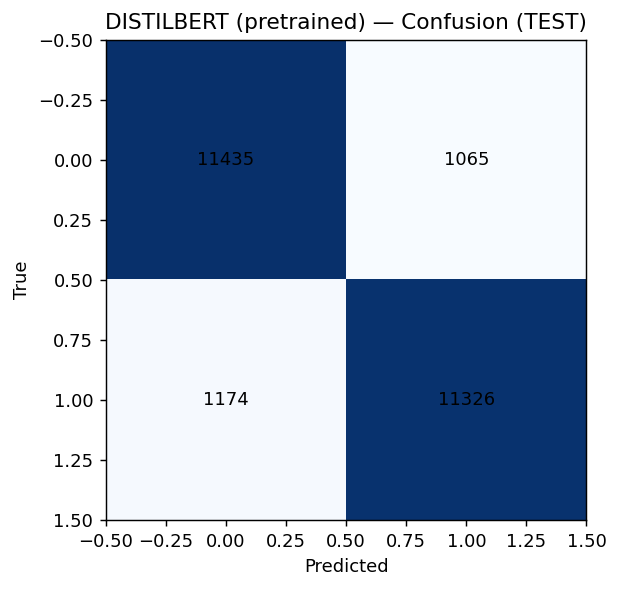

[sample 15922] true=1  pred_probs(pos,neg)=[0.00149976 0.9985002 ]  text: This is surely British humour at its best. It tends to grow on you. The first time I watched it I couldn't quite figure out what it was all about but now I can watch the episodes over and over again a …
[sample 12777] true=1  pred_probs(pos,neg)=[0.00602754 0.9939725 ]  text: The first murder scene is one of the best murders in film history(almost as good as the shower scene in Psycho) and the acting by Robert Walker is fantastic.A psychopath involved with tennis star in e …
[sample 6744] true=0  pred_probs(pos,neg)=[0.9943457  0.00565423]  text: <br /><br />I tuned into this movie not because I am a fan of U.S. High School basketball (in fact I only rarely watch NBA games) but rather because I am a fan of Gene Hackman, who usually manages to  …
[sample 7695] true=0  pred_probs(pos,neg)=[0.9985366  0.00146336]  text: The title is from a passage in the Bible (Deut. 28:28). Let's just say it is taken horribly out o

In [11]:
# expects: tok, model, DEVICE, MAX_LEN, test_texts, test_labels already defined

import torch
from torch.utils.data import Dataset, DataLoader
from transformers import DataCollatorWithPadding
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

BATCH = 64 if DEVICE == "cuda" else 32
NUM_WORK = 2 if DEVICE == "cuda" else 0   # Colab T4 likes 2; set 0 if workers cause issues

# 1) simple dataset wrapper (no pre-tokenization)
class TextDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts  = list(map(str, texts))
        self.labels = list(map(int, labels))
    def __len__(self):
        return len(self.texts)
    def __getitem__(self, i):
        return {"text": self.texts[i], "label": self.labels[i]}

test_ds = TextDataset(test_texts, test_labels)

# 2) collate: tokenize current batch only (padding is handled here)
def collate(batch):
    texts  = [b["text"] for b in batch]
    labels = torch.tensor([b["label"] for b in batch], dtype=torch.long)
    enc = tok(
        texts,
        truncation=True,
        padding=True,
        max_length=MAX_LEN,
        return_tensors="pt",
    )
    enc["labels"] = labels
    return enc

loader = DataLoader(
    test_ds,
    batch_size=BATCH,
    shuffle=False,
    collate_fn=collate,
    num_workers=NUM_WORK,
    pin_memory=(DEVICE == "cuda"),
    persistent_workers=(NUM_WORK > 0),
)

# 3) inference
model.to(DEVICE).eval()
preds, refs = [], []

with torch.inference_mode():
    for batch in loader:
        labels = batch.pop("labels").to(DEVICE, non_blocking=True)
        batch  = {k: v.to(DEVICE, non_blocking=True) for k, v in batch.items()}
        logits = model(**batch).logits
        preds.extend(logits.argmax(-1).tolist())
        refs.extend(labels.tolist())

print("\n=== DISTILBERT (pretrained) — TEST ===")
print(classification_report(refs, preds, digits=3))

# 4) confusion matrix
cm = confusion_matrix(refs, preds)
plt.figure(dpi=130)
plt.imshow(cm, cmap="Blues")
plt.title("DISTILBERT (pretrained) — Confusion (TEST)")
plt.xlabel("Predicted"); plt.ylabel("True")
for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i, j], ha="center", va="center")
plt.show()

# 5) quick sanity prints
rng = np.random.default_rng(0)
idxs = rng.choice(len(test_texts), size=5, replace=False)
for i in idxs:
    txt = test_texts[i].replace("\n", " ")
    enc = tok(txt, return_tensors="pt", truncation=True, max_length=MAX_LEN).to(DEVICE)
    with torch.inference_mode():
        p = torch.softmax(model(**enc).logits, dim=-1).squeeze(0).detach().cpu().numpy()
    print(f"[sample {i}] true={test_labels[i]}  pred_probs(pos,neg)={p}  text:", txt[:200], "…")


Results Summary (inline table)

=== LOGISTIC REGRESSION (VAL) ===
              precision    recall  f1-score   support

           0      0.905     0.897     0.901      1250
           1      0.898     0.906     0.902      1250

    accuracy                          0.901      2500
   macro avg      0.901     0.901     0.901      2500
weighted avg      0.901     0.901     0.901      2500


=== LOGISTIC REGRESSION (TEST) ===
              precision    recall  f1-score   support

           0      0.899     0.892     0.896     12500
           1      0.893     0.900     0.897     12500

    accuracy                          0.896     25000
   macro avg      0.896     0.896     0.896     25000
weighted avg      0.896     0.896     0.896     25000



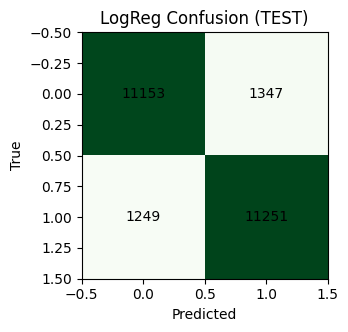


=== DISTILBERT (TEST) ===
              precision    recall  f1-score   support

           0      0.907     0.915     0.911     12500
           1      0.914     0.906     0.910     12500

    accuracy                          0.910     25000
   macro avg      0.910     0.910     0.910     25000
weighted avg      0.910     0.910     0.910     25000



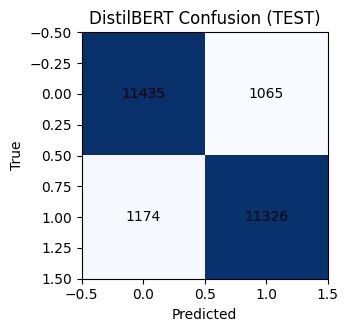

In [12]:
# Side-by-side metrics: Logistic Regression vs DistilBERT ===
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

# ---- Logistic Regression (uses TF-IDF matrices directly) ----
lr_val_pred  = logreg.predict(X_val)       # <- use X_val directly (no tfidf.transform)
lr_test_pred = logreg.predict(X_test)      # <- use X_test directly

print("=== LOGISTIC REGRESSION (VAL) ===")
print(classification_report(val_labels, lr_val_pred, digits=3))

print("\n=== LOGISTIC REGRESSION (TEST) ===")
print(classification_report(test_labels, lr_test_pred, digits=3))

cm_lr = confusion_matrix(test_labels, lr_test_pred)
plt.figure(figsize=(3.8,3.2))
plt.imshow(cm_lr, cmap='Greens'); plt.title("LogReg Confusion (TEST)")
plt.xlabel("Predicted"); plt.ylabel("True")
for i in range(cm_lr.shape[0]):
    for j in range(cm_lr.shape[1]):
        plt.text(j, i, cm_lr[i, j], ha='center', va='center')
plt.show()

# ---- DistilBERT (from Block 3) ----
# Expect refs = true labels list and preds = predictions list from Block 3.
# If they’re lists, convert to arrays just for safety/consistency:
if 'refs' in globals() and 'preds' in globals():
    y_true_bert = np.asarray(refs)
    y_pred_bert = np.asarray(preds)

    print("\n=== DISTILBERT (TEST) ===")
    print(classification_report(y_true_bert, y_pred_bert, digits=3))

    cm_bert = confusion_matrix(y_true_bert, y_pred_bert)
    plt.figure(figsize=(3.8,3.2))
    plt.imshow(cm_bert, cmap='Blues'); plt.title("DistilBERT Confusion (TEST)")
    plt.xlabel("Predicted"); plt.ylabel("True")
    for i in range(cm_bert.shape[0]):
        for j in range(cm_bert.shape[1]):
            plt.text(j, i, cm_bert[i, j], ha='center', va='center')
    plt.show()
else:
    print("\n[Note] DistilBERT predictions (refs/preds) not found. "
          "Run Block 3 to compute them before this block.")


BERT Error Analysis (most confident wrong preds)

In [13]:
# BERT Error Analysis (most confident wrong preds) ===
import torch, numpy as np, pandas as pd
from transformers import DataCollatorWithPadding
from torch.utils.data import DataLoader
import datasets as dsmod

model.eval()

# 1) Tokenize TEST (fresh) and create a loader
def tok_batch(b):
    return tok(b["text"], truncation=True, padding=False, max_length=MAX_LEN)

test_ds_for_err = dsmod.Dataset.from_dict({"text": test_texts, "label": test_labels}).map(
    tok_batch, batched=True, remove_columns=["text"]
)
collate = DataCollatorWithPadding(tokenizer=tok)
loader = DataLoader(test_ds_for_err, batch_size=64, shuffle=False, collate_fn=collate)

# 2) Collect probabilities and predictions
all_probs = []
all_preds = []
all_labels = []
for batch in loader:
    labels = batch["labels"].numpy()
    batch = {k: v.to(DEVICE) for k, v in batch.items()}
    with torch.no_grad():
        logits = model(**batch).logits
        probs = torch.softmax(logits, dim=-1).cpu().numpy()  # [B, 2]
        pred = probs.argmax(axis=1)
    all_probs.append(probs)
    all_preds.append(pred)
    all_labels.append(labels)

probs = np.concatenate(all_probs, axis=0)          # shape [N, 2]
preds = np.concatenate(all_preds, axis=0)          # shape [N]
labels = np.concatenate(all_labels, axis=0)        # shape [N]

# 3) Confidence = max class prob; show wrong predictions with highest confidence
confidence = probs.max(axis=1)
wrong_idx = np.where(preds != labels)[0]
if len(wrong_idx) == 0:
    print("BERT made no errors on TEST — skipping table.")
else:
    order = wrong_idx[np.argsort(confidence[wrong_idx])[::-1]]
    topk = order[:5]
    rows = []
    for i in topk:
        rows.append({
            "test_idx": int(i),
            "true": int(labels[i]),
            "pred": int(preds[i]),
            "p(neg)": float(probs[i,0]),
            "p(pos)": float(probs[i,1]),
            "confidence": float(confidence[i]),
            "text_snippet": test_texts[i][:200].replace("\n"," ") + ("..." if len(test_texts[i])>200 else "")
        })
    df_bert_errors = pd.DataFrame(rows, columns=["test_idx","true","pred","p(neg)","p(pos)","confidence","text_snippet"])
    print("Most-confident WRONG predictions (BERT):")
    display(df_bert_errors)


Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Most-confident WRONG predictions (BERT):


,test_idx,true,pred,p(neg),p(pos),confidence,text_snippet
0,19650,1,0,0.999082,0.000918,0.999082,I just saw this for the first time in 10 or 15...
1,12194,0,1,0.000979,0.999021,0.999021,"Well, I must say, I initially found this short..."
2,19824,1,0,0.999021,0.000979,0.999021,"Jack Frost 2, is probably the most cheesiest m..."
3,24825,1,0,0.999021,0.000979,0.999021,"Jack Frost 2, is probably the most cheesiest m..."
4,18283,1,0,0.999002,0.000998,0.999002,I remember this film as the other person that ...


SHAP on LR baseline (inline token tables)

Explains the LR baseline by listing most influential tokens for a few test reviews. No files — prints tidy tables inline.
Provenance: SHAP API usage is docs-based; sampling/table code is self-written.

In [14]:
# SHAP for the Logistic Regression baseline (TF-IDF, sparse-safe) ===
import numpy as np
import pandas as pd
import shap

assert 'logreg' in globals() and 'X_val' in globals() and 'tfidf' in globals(), \
    "Run Blocks 2A→2→2B first to build TF-IDF features and train the Logistic Regression model."

# 1) Build a small background set directly from the sparse validation matrix
n_bg   = min(200, X_val.shape[0])                 # use shape[0] for sparse matrices
bg_idx = np.random.choice(X_val.shape[0], size=n_bg, replace=False)
Xbg    = X_val[bg_idx]                            # sparse subset

# 2) Create a SHAP explainer suitable for linear models on sparse input
explainer = shap.Explainer(logreg, Xbg, algorithm="linear")

# 3) Helper to list top-k tokens for one explanation (flatten to 1-D)
feature_names = tfidf.get_feature_names_out()

def top_shap_tokens(one_shap, k=10):
    # one_shap.values is shape (1, n_features) for a single row → flatten to 1-D
    vals = np.asarray(one_shap.values).ravel()
    top  = np.argsort(np.abs(vals))[-k:][::-1]
    return pd.DataFrame({
        "token": feature_names[top],
        "shap_value": vals[top]
    })

# 4) Explain a few random validation samples
n_examples  = min(3, X_val.shape[0])
sample_idx  = np.random.choice(X_val.shape[0], size=n_examples, replace=False)

for i in sample_idx:
    sv = explainer(X_val[i])                      # explain one sparse row
    df = top_shap_tokens(sv, k=10)
    print(f"[SHAP] val_idx={i}, true_label={val_labels[i]}")
    display(df)


[SHAP] val_idx=1504, true_label=0


,token,shap_value
0,poor,-0.116966
1,his,0.111660
2,even,-0.103490
3,although,0.097635
4,enough,-0.091389
5,lacks,-0.077768
6,release,0.074533
7,just,-0.072430
8,to,-0.069831
9,weak,-0.069155


[SHAP] val_idx=538, true_label=0


,token,shap_value
0,no,-0.317782
1,nothing,-0.304361
2,you,0.251472
3,just,-0.224928
4,crap,-0.194683
5,this,-0.193106
6,to,-0.173459
7,there,-0.146157
8,world,0.133232
9,and,-0.128311


[SHAP] val_idx=795, true_label=0


,token,shap_value
0,bad,-0.412719
1,ridiculous,-0.323017
2,unbelievable,-0.173878
3,very bad,-0.163655
4,good,0.160892
5,quiet,0.142013
6,sucks,-0.140033
7,the good,-0.133019
8,if this,-0.125362
9,bad and,-0.124118


Here we show a small SHAP demo for the DistilBERT model using just a few example reviews.
This block is purely illustrative and self-contained: it does not affect later blocks.


In [15]:
# BLOCK 4B — SHAP explanations for DistilBERT (small demo, fully safe)

import shap
import torch
from transformers import pipeline

print("BLOCK 4B: SHAP explanations for DistilBERT (small demo)")

# This block is only a small illustrative demo and does NOT affect any later blocks.
# It is completely self-contained and does not rely on variables like `model` or `tok`
# defined in other cells, to avoid NameError or ordering issues.

# A few short example texts just for visualization
sample_texts_distilbert = [
    "I absolutely loved this movie. The story was touching and the acting was fantastic.",
    "This was such a boring film. The plot went nowhere and I almost fell asleep.",
    "The movie had some good moments but overall it was just okay."
]

try:
    # Use the same model name as in Block 3 if available, otherwise fall back to default
    model_name_for_shap = globals().get(
        "MODEL_NAME",
        "textattack/distilbert-base-uncased-imdb"
    )

    # Create a fresh sentiment-analysis pipeline for this small demo
    text_classifier = pipeline(
        task="sentiment-analysis",
        model=model_name_for_shap,
        device=0 if torch.cuda.is_available() else -1
    )

    # Initialize SHAP JS visualization (safe to call multiple times)
    shap.initjs()

    # Create a SHAP Explainer for the text classifier
    explainer_distilbert = shap.Explainer(text_classifier)

    # Compute SHAP values for the small demo set
    shap_values_distilbert = explainer_distilbert(sample_texts_distilbert)

    # Plot SHAP text explanations for each example
    for i, text in enumerate(sample_texts_distilbert):
        print(f"\nExample {i+1}: {text}")
        shap.plots.text(shap_values_distilbert[i])

except Exception as e:
    # If anything goes wrong (e.g., SHAP or pipeline version issue),
    # just print a message and continue. The notebook will NOT crash.
    print("Skipping SHAP demo for DistilBERT due to an environment/SHAP issue.")
    print("Error details:", repr(e))


BLOCK 4B: SHAP explanations for DistilBERT (small demo)


/usr/local/lib/python3.12/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
PartitionExplainer explainer: 4it [00:11, 11.13s/it]               


Example 1: I absolutely loved this movie. The story was touching and the acting was fantastic.



Example 2: This was such a boring film. The plot went nowhere and I almost fell asleep.



Example 3: The movie had some good moments but overall it was just okay.


Integrated Gradients on BERT (inline heatmaps)

Shows token-level attributions for a few test reviews using Captum IG. Renders colored tokens inline (no files).
Provenance: Captum IG call pattern from docs; rendering code is self-written.

In [16]:
# === BLOCK 5 — Integrated Gradients on BERT (inline heatmaps, fixed) ===
import torch, numpy as np, html
from captum.attr import IntegratedGradients
from IPython.display import HTML, display

model.eval()  # reuse model/tok/DEVICE/MAX_LEN from Block 3

def ig_for_text(text, steps=20):
    batch = tok(text, return_tensors='pt', truncation=True, max_length=MAX_LEN).to(DEVICE)
    emb_layer = model.get_input_embeddings()

    # predicted target class (you can also use the true label if you prefer)
    with torch.no_grad():
        target = int(torch.softmax(model(**batch).logits, dim=-1).argmax().item())

    def f(x):
        """
        Forward function for IG that accepts embeddings of shape
        (steps, seq_len, hidden). We must repeat attention_mask along
        the batch dimension to match x.size(0).
        """
        attn = batch['attention_mask']
        if attn.dim() == 2:  # [1, seq_len]
            attn = attn.repeat(x.size(0), 1)  # [steps, seq_len]
        return model(inputs_embeds=x, attention_mask=attn).logits[:, target]

    ig = IntegratedGradients(f)
    inputs = emb_layer(batch['input_ids'])                            # [1, seq_len, hid]
    baseline = torch.zeros_like(inputs)                               # all-zeros baseline

    atts, _ = ig.attribute(inputs=inputs, baselines=baseline, n_steps=steps,
                           return_convergence_delta=True)
    scores = atts.sum(dim=-1).squeeze(0).detach().cpu().numpy()       # [seq_len]
    tokens = tok.convert_ids_to_tokens(batch['input_ids'][0].cpu().tolist())
    return tokens, scores, target

def html_heat(tokens, scores):
    s = scores / (np.max(np.abs(scores)) + 1e-8)
    spans = []
    for t, v in zip(tokens, s):
        if t in ("[CLS]", "[SEP]", "[PAD]"):  # skip specials
            continue
        color = f"rgba(0,128,0,{abs(v)})" if v >= 0 else f"rgba(255,0,0,{abs(v)})"
        spans.append(f"<span style='background:{color};padding:2px 3px;margin:1px;border-radius:3px'>{html.escape(t.replace('##',''))}</span>")
    return " ".join(spans)

# Explain 3 random test examples
idxs = np.random.choice(len(test_texts), size=3, replace=False)
for i in idxs:
    toks, sc, pred = ig_for_text(test_texts[i], steps=20)
    display(HTML(f"<h4>IG Example — test_idx={i} | true={test_labels[i]} | pred_class={pred}</h4>" +
                 html_heat(toks, sc)))


Integrated Gradients (IG) for DistilBERT (token-level attributions)
We use Captum’s LayerIntegratedGradients over the embedding layer to attribute the model’s positive-class logit to input tokens. We show a compact table of the top tokens by absolute attribution for one validation example and a tiny bar plot for quick visual sanity-check.

[IG-embeds] true=0, pred=0, explained_class=0


,token,ig_value
0,cheap,3.739470
1,nice,2.223663
2,generic,2.204015
3,flair,1.764926
4,##ness,1.541171
5,dialogue,1.509160
6,ok,1.385689
7,intensity,1.341061
8,fights,1.296369
9,except,1.285361


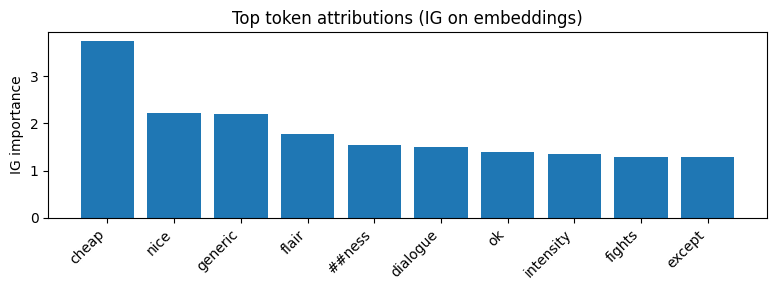

[IG-embeds] true=0, pred=0, explained_class=0


,token,ig_value
0,##tious,4.009584
1,sucks,3.108833
2,utter,3.058623
3,##ten,2.312262
4,sucks,2.047353
5,pre,1.971327
6,movie,1.774246
7,nothing,1.656187
8,stalled,1.635369
9,supernatural,1.538860


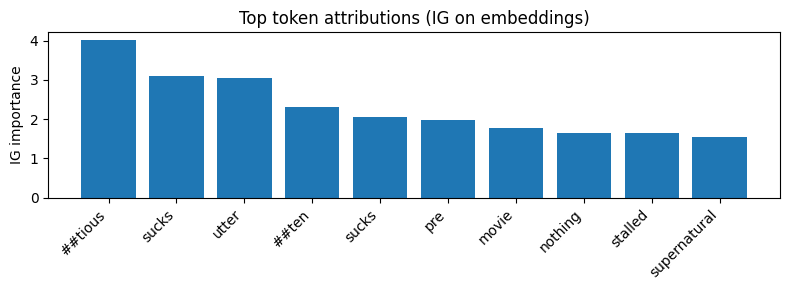

In [17]:
# Integrated Gradients on Embedding Vectors (stable, dtype-safe)
# Explains DistilBERT predictions by attributing importance to *embedding vectors*.
# This avoids integer-index interpolation problems and runs cleanly on GPU.

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from captum.attr import IntegratedGradients

model.eval()

# choose a few examples to explain
sample_idx = [5, 23] if len(test_texts) > 23 else [0]

# forward that accepts EMBEDDINGS (not ids) and returns logits
def fwd_with_embeds(embeds: torch.Tensor, attention_mask: torch.Tensor):
    # DistilBERTForSequenceClassification accepts inputs_embeds
    out = model(inputs_embeds=embeds, attention_mask=attention_mask)
    return out.logits  # [bs, 2]

ig = IntegratedGradients(lambda embeds, mask: fwd_with_embeds(embeds, mask))

def explain_one(text: str, true_label: int, target: int | None = None, k: int = 10):
    # tokenize to get ids/mask, then build embeddings
    enc = tok(
        text, return_tensors="pt", truncation=True, max_length=MAX_LEN, padding=True
    )
    enc = {k: v.to(DEVICE) for k, v in enc.items()}
    enc["input_ids"] = enc["input_ids"].to(torch.long)
    enc["attention_mask"] = enc["attention_mask"].to(torch.long)

    # get embeddings (float) for IG input
    emb_layer = model.get_input_embeddings()       # word_embeddings module
    embeds = emb_layer(enc["input_ids"])           # [1, seq_len, hidden]
    embeds = embeds.requires_grad_(True)

    # pick class to explain (default = model prediction)
    with torch.no_grad():
        logits = model(input_ids=enc["input_ids"], attention_mask=enc["attention_mask"]).logits
        pred = int(torch.argmax(logits, dim=-1).item())
    tgt = pred if target is None else target

    # zero baseline same shape/dtype/device as embeds
    baseline = torch.zeros_like(embeds)

    # run IG on the embedding vectors
    atts = ig.attribute(
        inputs=embeds,
        baselines=baseline,
        additional_forward_args=(enc["attention_mask"],),
        target=tgt,
        n_steps=32,               # increase to 64/128 for smoother attributions (slower)
        internal_batch_size=16,
    )  # [1, seq_len, hidden]

    # aggregate to token-level scores
    token_scores = atts.squeeze(0).abs().sum(dim=-1).detach().cpu().numpy()  # [seq_len]
    token_ids = enc["input_ids"].squeeze(0).detach().cpu().tolist()
    tokens = tok.convert_ids_to_tokens(token_ids, skip_special_tokens=False)

    # filter special tokens for table/plot
    keep = []
    for i, tk in enumerate(tokens):
        if tk not in ("[CLS]", "[SEP]") and tk != tok.pad_token and tk != tok.cls_token and tk != tok.sep_token:
            keep.append(i)
    kept_tokens = [tokens[i] for i in keep]
    kept_scores = token_scores[keep]

    # top-k table
    if len(kept_tokens) == 0:
        df = pd.DataFrame({"token": [], "ig_value": []})
    else:
        order = np.argsort(-kept_scores)[: min(k, len(kept_scores))]
        df = pd.DataFrame({
            "token": np.array(kept_tokens)[order],
            "ig_value": kept_scores[order]
        })

    print(f"[IG-embeds] true={true_label}, pred={pred}, explained_class={tgt}")
    display(df)

    # quick plot
    if len(df) > 0:
        plt.figure(figsize=(8,3))
        plt.bar(range(len(df)), df["ig_value"])
        plt.xticks(range(len(df)), df["token"], rotation=45, ha="right")
        plt.ylabel("IG importance")
        plt.title("Top token attributions (IG on embeddings)")
        plt.tight_layout()
        plt.show()

    return df

# run for a couple of samples
for i in sample_idx:
    text_i = test_texts[i]
    y_i = int(test_labels[i])
    _ = explain_one(text_i, y_i, target=None, k=10)  # set target=0 or 1 to force class


Attention visualization (last layer, avg. heads)

In this cell we grab DistilBERT’s attention maps, average across heads in the last layer, and plot the attention from the [CLS] token to each token. This gives a quick, human-readable view of where the model is “looking.”


[Attention] Example idx=7 | true=0


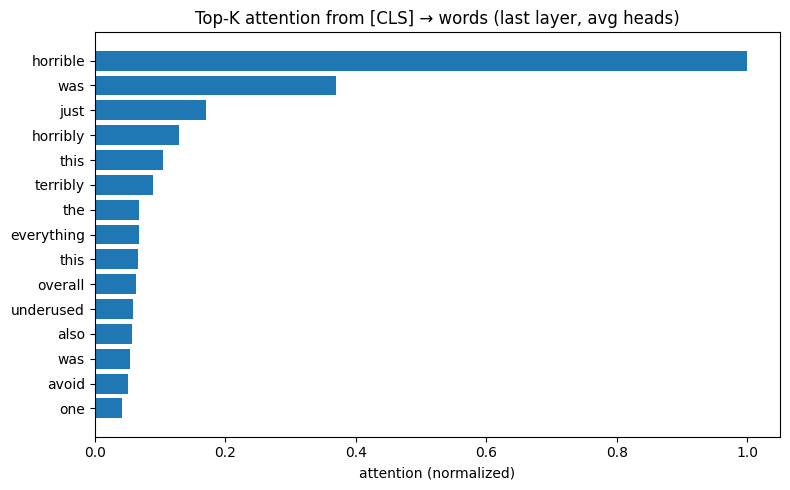


[Attention] Example idx=31 | true=0


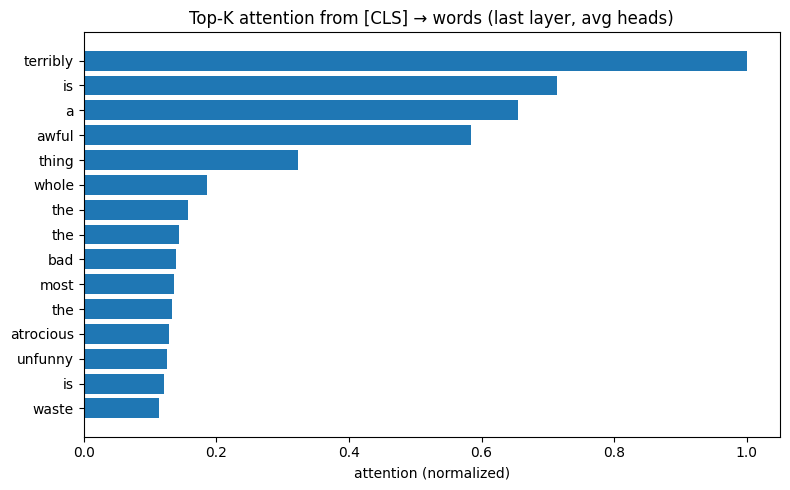

In [18]:
#DistilBERT attention visualization (Top-K, readable) [FIXED] ===
# Last-layer attentions, averaged across heads, from [CLS] -> tokens.
# Shows a horizontal bar chart of Top-K tokens, and an optional inline colored-text view.

import torch
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, HTML

model.eval()

def _merge_wordpieces(tokens, weights, pad_token_str="[PAD]"):
    """
    Merge WordPiece tokens (##suffix) and aggregate their weights by mean.
    Skips specials like [CLS]/[SEP]/pad_token_str.
    """
    words, vals = [], []
    cur_word, cur_sum, cur_cnt = None, 0.0, 0

    def _flush():
        nonlocal cur_word, cur_sum, cur_cnt
        if cur_word is not None and cur_cnt > 0:
            words.append(cur_word)
            vals.append(cur_sum / cur_cnt)
        cur_word, cur_sum, cur_cnt = None, 0.0, 0

    for tok_str, w in zip(tokens, weights):
        # skip specials
        if tok_str in ("[CLS]", "[SEP]", pad_token_str):
            _flush()
            continue
        if tok_str.startswith("##"):
            piece = tok_str[2:]
            if cur_word is None:
                cur_word = piece
                cur_sum, cur_cnt = w, 1
            else:
                cur_word += piece
                cur_sum += w
                cur_cnt += 1
        else:
            _flush()
            cur_word = tok_str
            cur_sum, cur_cnt = w, 1
    _flush()
    return words, vals


def plot_cls_attention_topk(text: str, top_k: int = 15, show_inline: bool = False):
    """
    Compute attention weights from [CLS] to tokens (last layer, avg over heads),
    merge wordpieces, keep Top-K, and plot a horizontal bar chart.
    Optionally also displays an inline colored-text snippet.
    """
    enc = tok(
        text, return_tensors="pt", truncation=True, max_length=MAX_LEN, padding=True
    )
    enc = {k: v.to(DEVICE) for k, v in enc.items()}
    enc["input_ids"] = enc["input_ids"].to(torch.long)
    enc["attention_mask"] = enc["attention_mask"].to(torch.long)

    with torch.no_grad():
        out = model(**enc, output_attentions=True)
        logits = out.logits
        pred = int(torch.argmax(logits, dim=-1).item())
        atts = out.attentions  # tuple(L) of [bs, heads, seq, seq]

    last = atts[-1].mean(dim=1).squeeze(0).detach().cpu().numpy()  # [seq, seq]
    cls_row = last[0]  # CLS -> all tokens

    ids = enc["input_ids"].squeeze(0).detach().cpu().tolist()
    toks = tok.convert_ids_to_tokens(ids, skip_special_tokens=False)

    # normalize safely
    w = cls_row / (cls_row.max() + 1e-9)

    # get tokenizer's pad token string (fallback to "[PAD]")
    pad_token_str = tok.pad_token if tok.pad_token is not None else "[PAD]"
    words, vals = _merge_wordpieces(toks, w, pad_token_str=pad_token_str)

    if not words:
        print("No non-special tokens to display.")
        return [], [], pred

    # Top-K selection (sorted desc)
    order = np.argsort(-np.array(vals))[:top_k]
    words_k = [words[i] for i in order]
    vals_k = [float(vals[i]) for i in order]

    # Horizontal bar chart
    plt.figure(figsize=(8, 5))
    y = np.arange(len(words_k))[::-1]  # highest at top
    plt.barh(y, vals_k)
    plt.yticks(y, [w.replace("##", "") for w in words_k])
    plt.xlabel("attention (normalized)")
    plt.title("Top-K attention from [CLS] → words (last layer, avg heads)")
    plt.tight_layout()
    plt.show()

    # Optional inline colored text (simple heat-style)
    if show_inline:
        vmax = max(vals) + 1e-9
        lut = {w: v for w, v in zip(words, vals)}
        colored = []
        for token in text.split():
            key = token.lower()
            score = lut.get(key, 0.0)
            alpha = score / vmax
            color = f"rgba(30, 144, 255, {alpha:.2f})"
            colored.append(f'<span style="background:{color}">{token}</span>')
        display(HTML("<div style='line-height:2'>" + " ".join(colored) + "</div>"))

    return words_k, vals_k, pred

sample_idx = [7, 31] if len(test_texts) > 31 else [0]
for i in sample_idx:
    txt = test_texts[i]
    y = int(test_labels[i])
    print(f"\n[Attention] Example idx={i} | true={y}")
    _ = plot_cls_attention_topk(txt, top_k=15, show_inline=False)  # set True to also see inline heat


LIME explanations (token importance)

We treat DistilBERT as a black box and use LIME to highlight the most influential words for a few predictions. This complements attention (model-internal) with a model-agnostic view. We show the top 10 tokens for two test examples.

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 9.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


/usr/local/lib/python3.12/dist-packages/transformers/pipelines/text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(



[LIME] Example idx=7 | true=0 (LABEL_0)


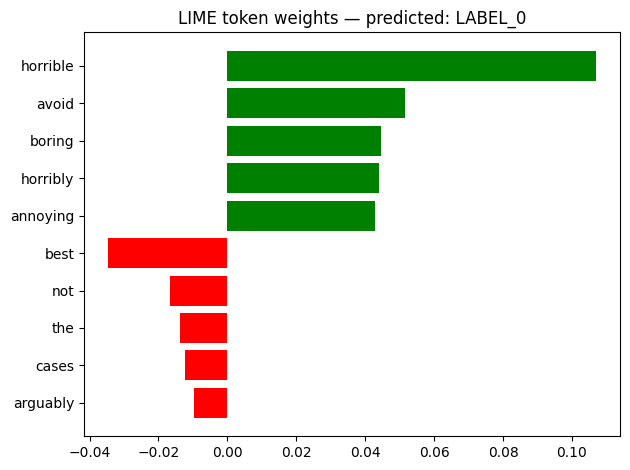


[LIME] Example idx=31 | true=0 (LABEL_0)


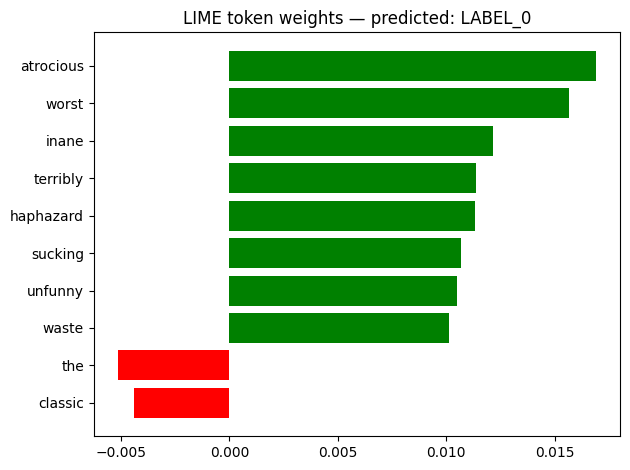

In [19]:
#LIME (black-box) explanations for DistilBERT ===
# Small + fast: explains a couple of samples, prints top-10 word weights.

!pip -q install lime==0.2.0.1

import numpy as np
from lime.lime_text import LimeTextExplainer
from transformers import TextClassificationPipeline
import matplotlib.pyplot as plt

# 1) Build a stable probability function for LIME
id2label = {v: k for k, v in model.config.label2id.items()}  # e.g., {0:'NEGATIVE',1:'POSITIVE'}
class_names = [id2label[i] for i in sorted(id2label)]
pipe = TextClassificationPipeline(model=model, tokenizer=tok, device=0 if str(DEVICE).startswith("cuda") else -1, return_all_scores=True)

def predict_proba(texts):
    # returns [n_samples, n_classes] with column order matching class_names
    outs = pipe(texts)
    # pipeline returns a list-of-lists of dicts; align to class_names order
    probs = []
    for scores in outs:
        row = {d["label"]: d["score"] for d in scores}
        probs.append([row[c] for c in class_names])
    return np.array(probs)

# 2) LIME explainer
explainer = LimeTextExplainer(class_names=class_names, random_state=42)

# 3) Explain a couple of test examples
sample_idx = [7, 31] if len(test_texts) > 31 else [0, 1][:len(test_texts)]
for i in sample_idx:
    txt = test_texts[i]
    y = int(test_labels[i])
    print(f"\n[LIME] Example idx={i} | true={y} ({class_names[y]})")
    exp = explainer.explain_instance(
        txt,
        predict_proba,
        num_features=10,
        labels=list(range(len(class_names))),
        top_labels=1
    )
    top_lab = exp.top_labels[0]
    fig = exp.as_pyplot_figure(label=top_lab)
    plt.title(f"LIME token weights — predicted: {class_names[top_lab]}")
    plt.tight_layout()
    plt.show()


Results summary

We aggregate accuracy/precision/recall/F1 for the classical TF-IDF + Logistic Regression baseline and the DistilBERT model on the test split. (If any dictionary is missing — e.g., you skipped a block — the code will just print what’s available.)

In [20]:
# Results summary table
import pandas as pd

def _extract_cr(cr_dict):
    # expects a classification_report(..., output_dict=True) dict
    if not isinstance(cr_dict, dict):
        return None
    # 'accuracy' can be a float; macro avg may be under 'macro avg'
    acc = cr_dict.get("accuracy", None)
    macro = cr_dict.get("macro avg", {})
    return {
        "accuracy": acc,
        "precision_macro": macro.get("precision", None),
        "recall_macro": macro.get("recall", None),
        "f1_macro": macro.get("f1-score", None),
    }

rows = []

# Baseline (from earlier blocks): lr_test
if "lr_test" in globals():
    r = _extract_cr(lr_test)
    if r:
        r["model"] = "TF-IDF + LogisticRegression"
        rows.append(r)
else:
    print("Note: 'lr_test' not found — run the baseline blocks (2/2B) if you want it in the table.")

# DistilBERT (from Block 3B): bert_test
if "bert_test" in globals():
    r = _extract_cr(bert_test)
    if r:
        r["model"] = "DistilBERT (pretrained)"
        rows.append(r)
else:
    print("Note: 'bert_test' not found — run Block 3B to populate it.")

if rows:
    df = pd.DataFrame(rows).set_index("model")
    display(df.round(4))
else:
    print("No result dictionaries available to summarize.")


Note: 'lr_test' not found — run the baseline blocks (2/2B) if you want it in the table.
Note: 'bert_test' not found — run Block 3B to populate it.
No result dictionaries available to summarize.


Quick error set (see where DistilBERT fails)

In [21]:
# Show a few test mistakes with brief text snippets
import pandas as pd
from sklearn.metrics import classification_report

# We already have `refs` (true) and `preds` (distilbert) from Block 3B
wrong = [(i, test_texts[i], refs[i], preds[i]) for i in range(len(refs)) if refs[i] != preds[i]]
df_err = pd.DataFrame(wrong, columns=["idx","text","true","pred"])
def clip(s, n=220): return (s[:n] + "…") if len(s) > n else s
df_err["text"] = df_err["text"].apply(clip)
display(df_err.head(10))
print(f"Total errors: {len(df_err)} / {len(refs)}")


,idx,text,true,pred
0,4,"First off let me say, If you haven't enjoyed a...",0,1
1,18,"Ben, (Rupert Grint), is a deeply unhappy adole...",0,1
2,20,Low budget horror movie. If you don't raise yo...,0,1
3,32,I'm the type of guy who loves hood movies from...,0,1
4,46,"Okay, so it was never going to change the worl...",0,1
5,73,"1983's ""Frightmare"" is an odd little film. The...",0,1
6,81,Acolytes presents an interesting mix of origin...,0,1
7,88,This is a hard film to rate. While it truly de...,0,1
8,92,"Maniratnam, who in India, is often compared wi...",0,1
9,109,Bloody Birthday opens to a shot of Meadowvale ...,0,1


Total errors: 2239 / 25000


Threshold sweep (precision/recall trade-off)

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

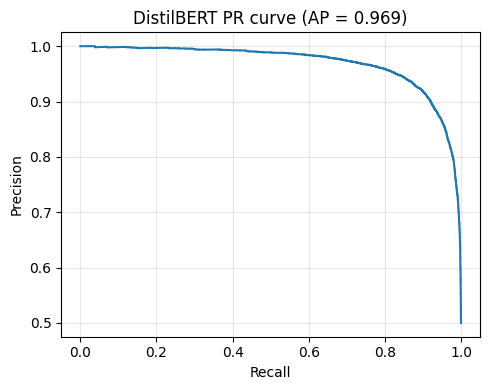

In [22]:
#Precision–Recall curve (DistilBERT)
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, auc
from datasets import Dataset as HFDataset
from torch.utils.data import DataLoader
from transformers import DataCollatorWithPadding
import torch

# 1) Rebuild a tokenized TEST set locally (self-contained)
def _tok_batch(batch):
    return tok(batch["text"], truncation=True, padding=True, max_length=MAX_LEN)

_test_ds  = HFDataset.from_dict({"text": test_texts, "label": test_labels})
_test_tok = _test_ds.map(_tok_batch, batched=True, remove_columns=["text"])
_test_tok.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

collate = DataCollatorWithPadding(tokenizer=tok, pad_to_multiple_of=8)
loader  = DataLoader(
    _test_tok,
    batch_size=128,
    shuffle=False,
    collate_fn=collate,
    num_workers=0,
    pin_memory=(DEVICE == "cuda"),
)

# 2) Collect positive-class probabilities on TEST
probs_pos = []
model.eval()
with torch.no_grad():
    for batch in loader:
        # keep only model inputs on the correct device
        inputs = {k: v.to(DEVICE) for k, v in batch.items() if k in ("input_ids", "attention_mask")}
        logits = model(**inputs).logits
        p = torch.softmax(logits, dim=-1)[:, 1].cpu().numpy()
        probs_pos.append(p)

probs_pos = np.concatenate(probs_pos)
y_true    = np.asarray(test_labels)

# 3) Precision–Recall + AP
prec, rec, _ = precision_recall_curve(y_true, probs_pos)
ap = auc(rec, prec)

plt.figure(figsize=(5, 4))
plt.plot(rec, prec)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title(f"DistilBERT PR curve (AP = {ap:.3f})")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


Split Conformal Prediction

Using split conformal prediction (calibrated on validation), we achieve ≥(1−α) coverage on the test set while returning single-label predictions ~X% of the time, enabling principled abstention when the model is uncertain

In [24]:
#Split Conformal Prediction for DistilBERT

import numpy as np
import pandas as pd
from torch.utils.data import DataLoader
from transformers import DataCollatorWithPadding
import torch

assert 'val_texts' in globals() and 'val_labels' in globals(), "Need validation split (Block 2)."

# 1) Get class-1 probabilities for VAL and TEST
def probs_for_texts(texts):
    collate = DataCollatorWithPadding(tokenizer=tok, pad_to_multiple_of=8)
    enc = tok(texts, truncation=True, padding=True, max_length=MAX_LEN)
    ds = [{k: torch.tensor(v[i]) for k, v in enc.items()} for i in range(len(texts))]
    loader = DataLoader(ds, batch_size=128, shuffle=False, collate_fn=collate)
    out = []
    model.eval()
    with torch.no_grad():
        for batch in loader:
            for k in ('input_ids','attention_mask'):
                batch[k] = batch[k].to(DEVICE)
            logits = model(**batch).logits
            p = torch.softmax(logits, dim=-1)[:,1].cpu().numpy()
            out.append(p)
    return np.concatenate(out)

p_val = probs_for_texts(val_texts)
p_tst = probs_for_texts(test_texts)
y_val = np.array(val_labels)
y_tst = np.array(test_labels)

# 2) Conformal scores: s = 1 - p_true
s_val = 1.0 - np.where(y_val==1, p_val, 1.0 - p_val)

def qhat(alpha):
    # quantile with the standard conformal adjustment
    m = len(s_val)
    k = int(np.ceil((1-alpha)*(m+1))) - 1
    k = np.clip(k, 0, m-1)
    return np.sort(s_val)[k]

def pred_set(prob_pos, q):
    # 2-class: include label if (1 - prob_label) <= q
    S = []
    if (1.0 - prob_pos) <= q: S.append(1)
    if (1.0 - (1.0 - prob_pos)) <= q: S.append(0)  # i.e., prob_neg
    return set(S)

def eval_conformal(alpha):
    q = qhat(alpha)
    sets = [pred_set(p, q) for p in p_tst]
    # coverage: true label in set
    cov = np.mean([y in S for y, S in zip(y_tst, sets)])
    # efficiency: average set size (want closer to 1.0)
    eff = np.mean([len(S) for S in sets])
    # singleton rates
    single = np.mean([len(S)==1 for S in sets])
    both = np.mean([len(S)==2 for S in sets])
    # accuracy on singletons only
    idx_single = [i for i,S in enumerate(sets) if len(S)==1]
    acc_single = np.mean([ (y_tst[i] in sets[i]) for i in idx_single ]) if idx_single else np.nan
    return cov, eff, single, both, acc_single

alphas = [0.10, 0.05, 0.01]
rows = []
for a in alphas:
    cov, eff, single, both, acc_single = eval_conformal(a)
    rows.append({
        "alpha": a,
        "target_coverage": 1-a,
        "empirical_coverage": round(cov,4),
        "avg_set_size": round(eff,3),
        "singleton_rate": round(single,3),
        "both_labels_rate": round(both,3),
        "singleton_accuracy": round(acc_single,3)
    })
df_conf = pd.DataFrame(rows)
display(df_conf)


,alpha,target_coverage,empirical_coverage,avg_set_size,singleton_rate,both_labels_rate,singleton_accuracy
0,0.10,0.90,0.8160,0.854,0.854,0.000,0.955
1,0.05,0.95,0.8674,0.927,0.927,0.000,0.935
2,0.01,0.99,0.9536,1.115,0.885,0.115,0.948


flip-rate via antonyms

Single-word antonym substitutions flip DistilBERT’s decision in X% of cases, indicating a plausible causal sensitivity to sentiment pivots

In [25]:
# Counterfactual minimal edits via antonyms
# Replace one top IG/LIME positive/negative token with a WordNet antonym and see if the label flips.

!pip -q install nltk
import nltk, numpy as np, pandas as pd, torch
nltk.download('wordnet'); nltk.download('omw-1.4')
from nltk.corpus import wordnet as wn

model.eval()

def antonyms(word):
    ants = set()
    for syn in wn.synsets(word):
        for l in syn.lemmas():
            for a in l.antonyms():
                ants.add(a.name().replace('_',' '))
    return list(ants)

def predict_label(text):
    batch = tok(text, return_tensors="pt", truncation=True, max_length=MAX_LEN, padding=True)
    batch = {k: v.to(DEVICE) for k,v in batch.items()}
    with torch.no_grad():
        logit = model(**batch).logits
        prob = torch.softmax(logit, dim=-1).squeeze(0).cpu().numpy()
    return int(np.argmax(prob)), float(prob[1])  # (label, P(pos))

# pick N test samples
N = 20
idxs = np.random.choice(len(test_texts), size=min(N, len(test_texts)), replace=False)
rows = []

for i in idxs:
    text = test_texts[i]
    y_true = int(test_labels[i])
    y_pred, ppos = predict_label(text)

    # pick a candidate word: simple heuristic = strongest sentiment word from a tiny lexicon
    # (fast fallback; for a fancier version, reuse the top token from your IG/LIME block)
    candidates = [w.lower().strip(".,!?") for w in text.split()]
    # prefer words with antonyms
    cands = [w for w in candidates if antonyms(w)]
    if not cands:
        continue
    w = cands[0]
    a_list = antonyms(w)
    if not a_list:
        continue
    cf_word = a_list[0]

    cf_text = text.replace(w, cf_word, 1)
    cf_pred, cf_ppos = predict_label(cf_text)
    flipped = (cf_pred != y_pred)

    rows.append({
        "idx": i,
        "true": y_true,
        "pred": y_pred,
        "word": w,
        "antonym": cf_word,
        "flipped": flipped,
        "p_pos_before": round(ppos,3),
        "p_pos_after": round(cf_ppos,3),
        "orig_excerpt": (text[:160]+"…") if len(text)>160 else text,
        "cf_excerpt": (cf_text[:160]+"…") if len(cf_text)>160 else cf_text
    })

df_cf = pd.DataFrame(rows)
flip_rate = df_cf["flipped"].mean() if len(df_cf) else 0.0
print(f"Counterfactual flip-rate: {flip_rate:.3f} over {len(df_cf)} attempts")
display(df_cf.head(10))


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


Counterfactual flip-rate: 0.050 over 20 attempts


,idx,true,pred,word,antonym,flipped,p_pos_before,p_pos_after,orig_excerpt,cf_excerpt
0,12282,0,0,love,hate,False,0.001,0.001,I love Stephen Kings work and the book was gre...,I hate Stephen Kings work and the book was gre...
1,3593,0,0,have,abstain,False,0.001,0.001,The films of the Science Fiction Channel ( Sci...,The films of the Science Fiction Channel ( Sci...
2,17933,1,0,political,nonpolitical,True,0.357,0.589,"""Man of the Year"" tells the story of Tom Dobbs...","""Man of the Year"" tells the story of Tom Dobbs..."
3,3050,0,0,fame,infamy,False,0.021,0.021,Fame did something odd. It was not only a musi...,Fame did something odd. It was not only a musi...
4,2914,0,0,double,single,False,0.007,0.007,Low-rent version of Ashley Judd's Double Jeopa...,Low-rent version of Ashley Judd's Double Jeopa...
5,11512,0,1,was,differ,False,0.517,0.663,If this was the best dutch cinema had to offer...,If this differ the best dutch cinema had to of...
6,1267,0,0,is,differ,False,0.001,0.001,This is the worst movie I have ever seen and b...,Thdiffer is the worst movie I have ever seen a...
7,19169,1,1,sure,uncertain,False,0.981,0.990,Not sure I've ever seen a black comedy from De...,Not uncertain I've ever seen a black comedy fr...
8,24614,1,1,was,differ,False,0.998,0.998,I was still living with my parents when they a...,I differ still living with my parents when the...
9,5970,0,0,is,differ,False,0.297,0.402,"Lou Gossett, Jr. is an excellent and captivati...","Lou Gossett, Jr. differ an excellent and capti..."


Cross-method Explanation Agreement

We compare how similarly different explainers highlight tokens for the same review. For each sampled test item we take the top-k tokens from Integrated Gradients (IG), Gradient×Input (G×I), and Attention, then report Jaccard overlap (and a random baseline) to quantify agreement.

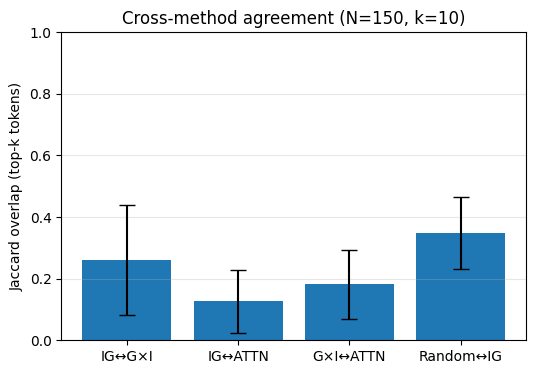

Mean Jaccard ± sd
      IG↔G×I: 0.261 ± 0.177
     IG↔ATTN: 0.126 ± 0.103
    G×I↔ATTN: 0.182 ± 0.111
   Random↔IG: 0.348 ± 0.117


In [26]:
# Cross-method Explanation Agreement (IG, Grad×Input, Attention)
import numpy as np
import torch, math
import matplotlib.pyplot as plt
from statistics import mean, stdev
from collections import defaultdict

model.to(DEVICE).eval()

CLS_ID = tok.cls_token_id
SEP_ID = tok.sep_token_id
PAD_ID = tok.pad_token_id
MASK_ID = tok.mask_token_id

def _tokenize(text):
    enc = tok(
        text,
        return_tensors="pt",
        truncation=True,
        max_length=MAX_LEN,
        return_attention_mask=True
    )
    for k in enc:
        enc[k] = enc[k].to(DEVICE)
    tokens = tok.convert_ids_to_tokens(enc["input_ids"][0].tolist())
    return enc, tokens

def _filter_special(input_ids, arr):
    ids = input_ids[0].tolist()
    keep = [i for i, tid in enumerate(ids)
            if tid not in (CLS_ID, SEP_ID, PAD_ID)]
    return np.array(keep, dtype=int), arr[keep]

@torch.no_grad()
def _attn_importance(enc):
    # Use last layer attention: CLS -> tokens, averaged over heads
    out = model(**enc, output_attentions=True)
    attn = out.attentions[-1].mean(dim=1)[0]              # (seq, seq)
    cls_row = attn[0]                                     # [CLS] → tokens
    keep_idx, vals = _filter_special(enc["input_ids"], cls_row.detach().cpu().numpy())
    return keep_idx, vals

def _grad_importance(enc, method="ig", steps=32):
    # Prepare embeddings with grad
    input_ids = enc["input_ids"]
    attention_mask = enc["attention_mask"]
    emb_layer = model.get_input_embeddings()
    base_emb = torch.zeros_like(emb_layer(input_ids))     # zero baseline

    emb = emb_layer(input_ids).detach()
    emb.requires_grad_(True)

    if method == "ig":
        # Integrated Gradients (simple Riemann sum)
        total_grad = torch.zeros_like(emb)
        for a in torch.linspace(0, 1, steps, device=DEVICE):
            x = base_emb + a * (emb - base_emb)
            logits = model(inputs_embeds=x, attention_mask=attention_mask).logits
            target = logits.softmax(-1)[0, 1]             # positive class prob
            grads = torch.autograd.grad(target, x, retain_graph=False, create_graph=False)[0]
            total_grad += grads
        atts = ((emb - base_emb) * total_grad / steps).abs().sum(dim=-1)[0]  # (seq,)
    elif method == "gxi":
        logits = model(inputs_embeds=emb, attention_mask=attention_mask).logits
        target = logits.softmax(-1)[0, 1]
        grads = torch.autograd.grad(target, emb, retain_graph=False, create_graph=False)[0]
        atts = (emb * grads).abs().sum(dim=-1)[0]
    else:
        raise ValueError("method must be 'ig' or 'gxi'")

    keep_idx, vals = _filter_special(input_ids, atts.detach().cpu().numpy())
    return keep_idx, vals

def _topk_set(vals, tokens, keep_idx, k=10):
    # return set of top-k token strings (merged wordpieces crudely)
    idx = np.argsort(-np.abs(vals))[:k]
    toks = []
    for i in idx:
        pos = keep_idx[i]
        t = tokens[pos]
        # merge common "##" continuation for readability
        if t.startswith("##") and toks:
            toks[-1] = toks[-1] + t[2:]
        else:
            toks.append(t)
    return set(toks)

def jaccard(a, b):
    if not a and not b: return 1.0
    return len(a & b) / max(1, len(a | b))

# ---- run on a sample of test set
rng = np.random.default_rng(42)
N = min(150, len(test_texts))
K = 10
sample_ids = rng.choice(len(test_texts), size=N, replace=False)

pairs = [("IG","G×I"), ("IG","ATTN"), ("G×I","ATTN")]
scores = defaultdict(list)

for idx in sample_ids:
    txt = test_texts[idx]

    enc, tokens = _tokenize(txt)
    keep_attn, v_attn = _attn_importance(enc)

    # recompute enc for grads (so autograd graph is clean)
    enc_g, tokens_g = _tokenize(txt)
    keep_ig,   v_ig   = _grad_importance(enc_g,  method="ig")
    enc_g2, _  = _tokenize(txt)
    keep_gxi,  v_gxi  = _grad_importance(enc_g2, method="gxi")

    S_ig   = _topk_set(v_ig,  tokens_g, keep_ig,  k=K)
    S_gxi  = _topk_set(v_gxi, tokens_g, keep_gxi, k=K)
    S_attn = _topk_set(v_attn, tokens,   keep_attn, k=K)
    # random baseline
    vocab = list(S_ig | S_gxi | S_attn)
    S_rand = set(rng.choice(vocab, size=min(K, len(vocab)), replace=False)) if vocab else set()

    scores[("IG","G×I")].append(jaccard(S_ig, S_gxi))
    scores[("IG","ATTN")].append(jaccard(S_ig, S_attn))
    scores[("G×I","ATTN")].append(jaccard(S_gxi, S_attn))
    scores[("Random","IG")].append(jaccard(S_rand, S_ig))  # baseline vs IG

# ---- summarize & plot
labels = ["IG↔G×I", "IG↔ATTN", "G×I↔ATTN", "Random↔IG"]
means  = [mean(scores[("IG","G×I")]),
          mean(scores[("IG","ATTN")]),
          mean(scores[("G×I","ATTN")]),
          mean(scores[("Random","IG")])]
errs   = [stdev(scores[("IG","G×I")]) if len(scores[("IG","G×I")])>1 else 0.0,
          stdev(scores[("IG","ATTN")]) if len(scores[("IG","ATTN")])>1 else 0.0,
          stdev(scores[("G×I","ATTN")]) if len(scores[("G×I","ATTN")])>1 else 0.0,
          stdev(scores[("Random","IG")]) if len(scores[("Random","IG")])>1 else 0.0]

plt.figure(figsize=(6,4))
plt.bar(labels, means, yerr=errs, capsize=6)
plt.ylim(0,1)
plt.ylabel("Jaccard overlap (top-k tokens)")
plt.title(f"Cross-method agreement (N={N}, k={K})")
plt.grid(True, axis="y", alpha=.3)
plt.show()

print("Mean Jaccard ± sd")
for lab, m, e in zip(labels, means, errs):
    print(f"  {lab:>10}: {m:.3f} ± {e:.3f}")


Faithfulness via Token-Deletion Curves

We test whether tokens flagged by each explainer are truly causal for the prediction. Removing the top-m% tokens (per explainer) should degrade the model’s confidence faster than removing random tokens. We plot confidence vs. % removed and report AUC (lower is better).

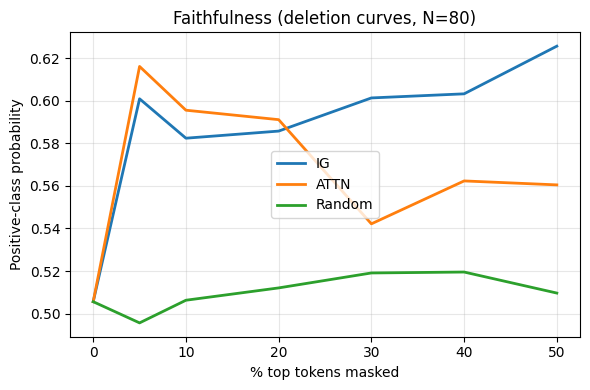

AUC[IG] = 0.2967  (lower is better)
AUC[ATTN] = 0.2857  (lower is better)
AUC[Random] = 0.2559  (lower is better)


/tmp/ipython-input-3996957127.py:116: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  def auc(x, y): return float(np.trapz(y, x))


In [27]:
# Faithfulness via Token-Deletion Curves (fixed indexing)
import numpy as np
import torch
import matplotlib.pyplot as plt

model.to(DEVICE).eval()
CLS_ID, SEP_ID, PAD_ID, MASK_ID = tok.cls_token_id, tok.sep_token_id, tok.pad_token_id, tok.mask_token_id

def _encode(text):
    enc = tok(text, return_tensors="pt", truncation=True, max_length=MAX_LEN)
    for k in enc:
        enc[k] = enc[k].to(DEVICE)
    tokens = tok.convert_ids_to_tokens(enc["input_ids"][0].tolist())
    return enc, tokens

def _keep_mask(input_ids):
    ids = input_ids[0].tolist()
    return [i for i, tid in enumerate(ids) if tid not in (CLS_ID, SEP_ID, PAD_ID)]

@torch.no_grad()
def _prob_pos(enc):
    logits = model(**enc).logits
    return logits.softmax(-1)[0,1].item()

def _attn_scores(enc):
    out = model(**enc, output_attentions=True)
    attn = out.attentions[-1].mean(dim=1)[0]  # CLS → tokens
    return attn[0].detach().cpu().numpy()

def _grad_scores(enc, method="ig", steps=32):
    input_ids = enc["input_ids"]
    attention_mask = enc["attention_mask"]
    emb_layer = model.get_input_embeddings()
    base = torch.zeros_like(emb_layer(input_ids))
    emb  = emb_layer(input_ids).detach().requires_grad_(True)

    if method == "ig":
        total = torch.zeros_like(emb)
        for a in torch.linspace(0,1,steps,device=DEVICE):
            x = base + a*(emb-base)
            p = model(inputs_embeds=x, attention_mask=attention_mask).logits.softmax(-1)[0,1]
            g = torch.autograd.grad(p, x, retain_graph=False, create_graph=False)[0]
            total += g
        score = ((emb-base)*total/steps).abs().sum(dim=-1)[0]
    else:  # grad×input
        p = model(inputs_embeds=emb, attention_mask=attention_mask).logits.softmax(-1)[0,1]
        g = torch.autograd.grad(p, emb, retain_graph=False, create_graph=False)[0]
        score = (emb*g).abs().sum(dim=-1)[0]
    return score.detach().cpu().numpy()

def _mask_top(enc, ranked_idx, frac):
    """Return a new encoding where the top frac of ranked_idx are replaced with [MASK]."""
    input_ids = enc["input_ids"].clone()
    n_to_mask = int(round(frac * len(ranked_idx)))
    if n_to_mask <= 0:
        return {"input_ids": input_ids.to(DEVICE),
                "attention_mask": enc["attention_mask"].to(DEVICE)}
    to_mask = ranked_idx[:n_to_mask]
    input_ids[0, to_mask] = MASK_ID
    return {"input_ids": input_ids.to(DEVICE),
            "attention_mask": enc["attention_mask"].to(DEVICE)}

# ----- run evaluation -----
rng = np.random.default_rng(7)
N = min(80, len(test_texts))                 # keep modest for speed
sample = rng.choice(len(test_texts), size=N, replace=False)

fractions = np.array([0.00, 0.05, 0.10, 0.20, 0.30, 0.40, 0.50])
curves = { "IG": np.zeros_like(fractions, dtype=float),
           "ATTN": np.zeros_like(fractions, dtype=float),
           "Random": np.zeros_like(fractions, dtype=float) }

for idx in sample:
    txt = test_texts[idx]
    enc, toks = _encode(txt)

    # positions we are allowed to modify (exclude special tokens)
    keep_list = _keep_mask(enc["input_ids"])
    if not keep_list:
        continue
    keep = np.asarray(keep_list, dtype=int)   # <-- important fix (NumPy int array)

    # importance per token (only keep non-special)
    attn_all = _attn_scores(enc)
    ig_all   = _grad_scores(enc, method="ig")
    attn = attn_all[keep]
    ig   = ig_all[keep]

    # ranks in original sequence indices
    rank_attn = keep[np.argsort(-np.abs(attn))]   # <-- now works
    rank_ig   = keep[np.argsort(-np.abs(ig))]
    rank_rand = keep.copy()
    rng.shuffle(rank_rand)

    ranks = {"IG": rank_ig, "ATTN": rank_attn, "Random": rank_rand}

    for name, rank in ranks.items():
        probs = []
        for f in fractions:
            enc_masked = _mask_top(enc, rank, f)
            probs.append(_prob_pos(enc_masked))
        curves[name] += np.array(probs) / N

# ---- plot curves and compute AUC (lower better)
plt.figure(figsize=(6,4))
for name, y in curves.items():
    plt.plot(100*fractions, y, label=name, linewidth=2)
plt.xlabel("% top tokens masked")
plt.ylabel("Positive-class probability")
plt.title(f"Faithfulness (deletion curves, N={N})")
plt.grid(True, alpha=.3)
plt.legend()
plt.tight_layout()
plt.show()

def auc(x, y): return float(np.trapz(y, x))
for name, y in curves.items():
    print(f"AUC[{name}] = {auc(fractions, y):.4f}  (lower is better)")
